In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath("./")))
from ase.build.ribbon import graphene_nanoribbon
from TB.hamiltonian import Hamiltonian
from TB.orbitals import Orbitals
from calc.utils import finite_difference
from TB.hamiltonian_initializer import set_tb_params, set_tb_params_bond_length
import torch
from calc.NEGF import NEGF
import matplotlib.pyplot as plt

def create_graphene_nanoribbon(w=3.5, l=5):
    atoms = graphene_nanoribbon(w, l, type='armchair', saturated=True)

    period = np.array([list(atoms.get_cell()[2])])
    period[:, [1, 2]] = period[:, [2, 1]]
    coord = atoms.get_positions()

    coord[:, [1, 2]] = coord[:, [2, 1]]
    coords = []
    coords.append(str(len(coord)))
    coords.append('Nanoribbon')

    for j, item in enumerate(coord):
        coords.append('C' + str(j + 1) + ' ' + str(item[0]) + ' ' + str(item[1]) + ' ' + str(item[2]))

    coords = '\n'.join(coords)

    return period, coords

import numpy as np

def radial_dependence_func(bond_length, ne_bond_length, param):

        return (bond_length / ne_bond_length) ** param
        # return torch.exp(-param*(ne_bond_length/bond_length-1))

def sorting(coords, **kwargs):
    return np.argsort(coords[:, 1], kind='mergesort')

gamma0 = -2.97
gamma1 = -0.073
gamma2 = -0.33
s0 = 0.073
s1 = 0.018
s2 = 0.026



In [2]:
import time
import resource

period, coords = create_graphene_nanoribbon(w=3.5, l=1)

s_orb = Orbitals('C')
s_orb.add_orbital("pz", energy=-0.28, orbital=1, magnetic=0, spin=0)

set_tb_params(s_orb, PARAMS_C_C1={'pp_pi': gamma0},
                PARAMS_C_C2={'pp_pi': gamma1},
                PARAMS_C_C3={'pp_pi': gamma2},
                OV_C_C1={'pp_pi': s0},
                OV_C_C2={'pp_pi': s1},
                OV_C_C3={'pp_pi': s2})

h = Hamiltonian(xyz=coords, xyz_new=coords, nn_distance=[1.5, 2.5, 3.1], comp_overlap=True, sort_func=sorting).initialize()
h.set_periodic_bc(period)
n_a = h.get_site_coordinates().shape[0]

hL, hD, hR, sL, sD, sR = h.get_hamiltonians()
hl_list, hd_list, hr_list, sl_list, sd_list, sr_list, subblocks = \
    h.get_hamiltonians_block_tridiagonal(optimized=True)
    

def pack(**options):
    return options

hmt_ovp = pack(hd=hd_list,hu=hr_list,hl=hl_list,sd=sd_list,su=sr_list,sl=sl_list,lhd=hD,lhu=hL.conj().T,lsd=sD,lsu=sL.conj().T,rhd=hD,rhu=hR,rsd=sD,rsu=sR)
# plt.matshow(hD.detach().real, vmin=-5, vmax=0.5)
# plt.colorbar()
negf = NEGF(hmt_ovp)

ee = torch.linspace(-1, 1, 351)
ee.requires_grad_()

result = negf.calGreen(
    ee = ee,
    ul = 0.,
    ur = 1,
    calSeebeck=False,
    calTT=True,
    cutoff=True,
    ifSCF=False,
    d_trains=1,
    left_pos=period[0][0],
    right_pos=period[0][1],
    atom_coord=h.get_site_coordinates()[h._offsets],
    offset=h._offsets,
    sgfMethod="other",
    etaLead=1e-3,
    etaDevice=1e-3
)




C


In [3]:
from torch.autograd import grad


dTE = grad(result["TT"].sum(), ee, create_graph=True)[0]
ddTE = grad(dTE.sum(), ee, create_graph=True)[0]
dddTE = grad(ddTE.sum(), ee)[0]


In [4]:
dddTE_FD = (ddTE[1:] - ddTE[:-1]) / (ee[1:] - ee[:-1])
ddTE_FD = (dTE[1:] - dTE[:-1]) / (ee[1:] - ee[:-1])
dTE_FD = (result["TT"][1:] - result["TT"][:-1]) / (ee[1] - ee[0])

[]

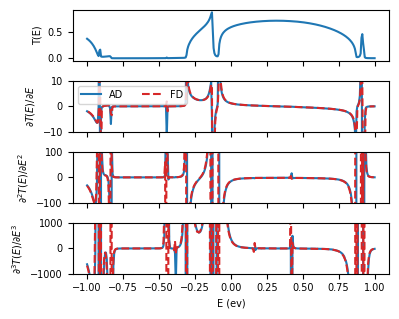

In [19]:
import matplotlib

matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['pdf.fonttype'] = 42

fig, (ax) = plt.subplots(4, 1, sharex=True, figsize=(4.0, 3.2))

ax[0].plot(ee.detach(), result["TT"].detach(), c="tab:blue")

ax[1].plot(ee.detach(),dTE.detach(), c="tab:blue")
ax[1].plot(ee[1:].detach(),dTE_FD.detach(), "--", c="tab:red")

ax[2].plot(ee.detach(),ddTE.detach(), c="tab:blue")
ax[2].plot(ee.detach()[:-1],ddTE_FD.detach(), "--", c="tab:red")

ax[3].plot(ee.detach(),dddTE.detach(), c="tab:blue")
ax[3].plot(ee.detach()[:-1],dddTE_FD.detach(), "--", c="tab:red")

# plt.xlim((-0.03,0.03))
# plt.ylim((-5,5))
ax[1].set_ylim((-10,10))
ax[2].set_ylim((-100,100))
ax[3].set_ylim((-1000,1000))
plt.xlabel("E (ev)")


ax[0].set_ylabel("T(E)")
ax[1].set_ylabel(r"$\partial T(E) / \partial E$")
ax[2].set_ylabel(r"$\partial^2 T(E) / \partial E^2$")
ax[3].set_ylabel(r"$\partial^3 T(E) / \partial E^3$")

ax[1].legend(["AD", "FD"], ncol=2, loc="upper left")
# plt.text(-1.08,600,"T(E)")
# plt.text(-1.08,300,r"$\frac{\partial T(E)}{\partial E}$")
# plt.text(-1.08,30,r"$\frac{\partial^2 T(E)}{\partial E^2}$")
plt.tight_layout()
plt.savefig("../img/high_order.pdf", dpi=100)
plt.plot()

